#Model Info:
A Gru based Encoder and Decoder with Attention mechanism.
Model's Architecture
          


* Model's Architecture
          Encoder:  Uni-directional GRU, 1 layer of GRU cells used
          Decoder: Uni-directional GRU with Attention mechanism
          Optimizer: Stochastic gradient descent (SGD)
          Loss Criterion:  Negative log-likelihood(NLL) Loss
          Dropout technique is also used with probability= 0.1
          Learning rate=0.01
 
 
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Making all necessary allowed imports

In [ ]:

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import matplotlib.pyplot as plt
import math


#Creating vocab using  dictionary together with some preprocessing all visualisation 

In [ ]:

i=0
data={}
with open('/content/drive/MyDrive/train/train.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    for row in reader:
        if i==0:
            i+=1
            continue
        else:
            data[row[0]]={}
            data[row[0]]['src']=row[1]
            data[row[0]]['trg']=row[2]

SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

j=0
test_data={}
with open('hindistatements.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    for row in reader:
        if j==0:
            j+=1
            continue
        else:
            test_data[row[1]]={}
            test_data[row[1]]['src']=row[2]
            test_data[row[1]]['trg']=data[row[1]]['trg']

In [ ]:
print(test_data['0']['src'])

- अंतरिक्ष वाले लोग?


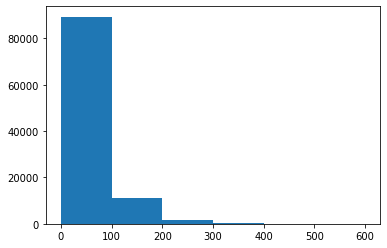

In [ ]:
all_len=[]
for x in range(len(data)):
    all_len.append(len(data[str(x)]['src']))


plt.hist(all_len, bins=[0,100,200,300,400,500,600])
plt.show()


# some work to find outliers based on length of sentences and remove them 

In [ ]:
print(min(all_len))
print(all_len.index(min(all_len)))
print(data['5933']['trg'])
n = len(all_len)
Range = max(all_len)- min(all_len)
intervals = math.sqrt(n)
Width= Range // intervals 
print(Range)

1
5933
Huh?
2087


In [ ]:
hindi_len=[0,0,0,0,0,0,0]
for x in range(len(data)):
    if len(data[str(x)]['src'])<=100:
        hindi_len[0]+=1
    
    if 100<len(data[str(x)]['src'])<=200:
        hindi_len[1]+=1
        
    
    if 200<len(data[str(x)]['src'])<=300:
        hindi_len[2]+=1

    if 300<len(data[str(x)]['src'])<=400:
        hindi_len[3]+=1

    if 400<len(data[str(x)]['src'])<=500:
        hindi_len[4]+=1

    if 500<len(data[str(x)]['src'])<=600:
        hindi_len[5]+=1

    if len(data[str(x)]['src'])>600:
        hindi_len[6]+=1
    
    

In [ ]:
print('number of sentences of length less than 100,200,...so on')
print(hindi_len)

for x in list(data):
    if len(data[x]['src'])>300:
        result = data.pop(x, None)
        
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

number of sentences of length less than 100,200,...so on
[89622, 10892, 1490, 243, 52, 15, 8]


In [ ]:

pairs=[]
for x in data:
    pairs.append([data[x]['src'],data[x]['trg']])

input_lang = Lang('hindi')
output_lang = Lang('english')
print("Total numbwer of Training examples after preprocessing:" , len(pairs))
for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
for x in test_data:
    input_lang.addSentence(test_data[x]['src'])
print("=========== Words in vocab ==============")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)


Total numbwer of Training examples after preprocessing: 102004
=========== Words in vocab ==============
hindi 72018
english 73520


# The template for the Encoder and Attention decoder Architecture 
This section uses framework provided in the pytorch tutorial heavily


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttentionGRU(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=100):
        super(AttentionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

cuda


#Traiing the model and measuring its performance  on the training dataset

In [ ]:

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=100):
    

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    encoder_hidden = encoder.initHidden()

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < 0.4 else False

    if use_teacher_forcing == True:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  

    else:
    
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() 

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def Measure(encoder, decoder, n_iters, print_every=1000, learning_rate=0.01):

    if device=='cuda':

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() 

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    print_loss_total = 0  
    plot_loss_total = 0  

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Training examples processed:',iter)
            print('Total average loss:, ', round(print_loss_avg,3))

    indexes = [input_lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    input_tensor=torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
    input_length = input_tensor.size()[0]

hidden_size = 256
encoder = EncoderGRU(input_lang.n_words, hidden_size).to(device)
decoder = AttentionGRU(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

Epochs=20
for e in range(Epochs):
    print("Epoch :",e+1)
    Measure(encoder, decoder, 100000, print_every=5000)
    print("=================================================================")

# Get predicted translation by the model.
Fetching the predicted Translation and saving it in answer.txt

In [ ]:
file1 = open("answer.txt","w")

def Translator(encoder, decoder, sentence, max_length=100):
    with torch.no_grad():
        
        indexes = [input_lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        input_tensor=torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device) 

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


for x in test_data:
    output_words = Translator(encoder, decoder, test_data[x]['src'])
    output_words.pop()
    output_sentence = ' '.join(output_words)
    file1.write(output_sentence+'\n')

file1.close()